In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import spacy
import torchvision.utils as vutils
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
class ConditionalGenerator(nn.Module):
    def __init__(self, nz, ngf, nc, text_embedding_dim):
        super(ConditionalGenerator, self).__init__()
        self.label_embedding = nn.Linear(text_embedding_dim, nz)
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz * 2, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, text_embedding):
        text_embedding = self.label_embedding(text_embedding)
        # Reshape text embedding to match the noise tensor dimensions
        text_embedding = text_embedding.unsqueeze(-1).unsqueeze(-1)  # Change shape from [batch_size, nz] to [batch_size, nz, 1, 1]
        combined_input = torch.cat((noise, text_embedding), 1)
        return self.main(combined_input)

# Discriminator network
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Install the spaCy model
!python -m spacy download en_core_web_md


In [5]:
# Custom dataset class for images and descriptions
class CustomDataset(Dataset):
    def __init__(self, root_image_dir, root_text_dir, transform=None):
        self.root_image_dir = root_image_dir
        self.root_text_dir = root_text_dir
        self.image_files = os.listdir(root_image_dir)
        self.text_files = os.listdir(root_text_dir)
        self.transform = transform

    def __len__(self):
        return min(len(self.image_files), len(self.text_files))

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_image_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)

        text_name = os.path.join(self.root_text_dir, self.text_files[idx])
        with open(text_name, 'r') as file:
            description = file.read()

        return image, description

# Load the spaCy English model for text processing
nlp = spacy.load("en_core_web_md")

In [6]:
save_dir = '/kaggle/working/generated_images'  
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [7]:
# Function to encode a sentence into a vector
def encode_sentence(sentence):
    with torch.no_grad():
        tokenized = nlp(sentence)
        word_embeddings = [token.vector for token in tokenized if token.is_alpha]
        if word_embeddings:
            encoded_vector = torch.tensor(np.mean(word_embeddings, axis=0), dtype=torch.float32)
            if encoded_vector.size(0) < nz:
                encoded_vector = torch.cat((encoded_vector, torch.zeros(nz - encoded_vector.size(0))))
            elif encoded_vector.size(0) > nz:
                encoded_vector = encoded_vector[:nz]
            return encoded_vector
        else:
            return torch.zeros(nz, dtype=torch.float32)

In [8]:
# Hyperparameters and setup
batch_size = 16
image_size = 64
nc = 3
nz = 128
ngf = 64
ndf = 64
num_epochs = 200
text_embedding_dim = nz  # Adjust based on your embedding size

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CustomDataset(root_image_dir="/kaggle/input/cars-data/image_cars/image_cars",
                        root_text_dir="/kaggle/input/cars-data/names_cars/names_cars",
                        transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
netG = ConditionalGenerator(nz, ngf, nc, text_embedding_dim).to(device)
netD = Discriminator(nc, ndf).to(device)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

[0/200][0/313] Loss_D: 0.6059417724609375 Loss_G: 1.3518548011779785
[0/200][50/313] Loss_D: 1.1561088562011719 Loss_G: 2.674497127532959
[0/200][100/313] Loss_D: 0.8271167874336243 Loss_G: 2.663649320602417
[0/200][150/313] Loss_D: 0.5780174136161804 Loss_G: 3.40624737739563
[0/200][200/313] Loss_D: 0.4690384268760681 Loss_G: 3.8798913955688477
[0/200][250/313] Loss_D: 1.2187047004699707 Loss_G: 2.6426284313201904
[0/200][300/313] Loss_D: 0.8454610705375671 Loss_G: 2.9818129539489746
[1/200][0/313] Loss_D: 0.8410164713859558 Loss_G: 3.46482515335083
[1/200][50/313] Loss_D: 0.9603766202926636 Loss_G: 3.0896363258361816
[1/200][100/313] Loss_D: 1.054780125617981 Loss_G: 4.82395601272583
[1/200][150/313] Loss_D: 0.9941840767860413 Loss_G: 1.5518474578857422
[1/200][200/313] Loss_D: 0.8501486778259277 Loss_G: 4.399320602416992
[1/200][250/313] Loss_D: 0.6205503940582275 Loss_G: 3.3914127349853516
[1/200][300/313] Loss_D: 0.9223021268844604 Loss_G: 2.9517879486083984
[2/200][0/313] Loss_D:

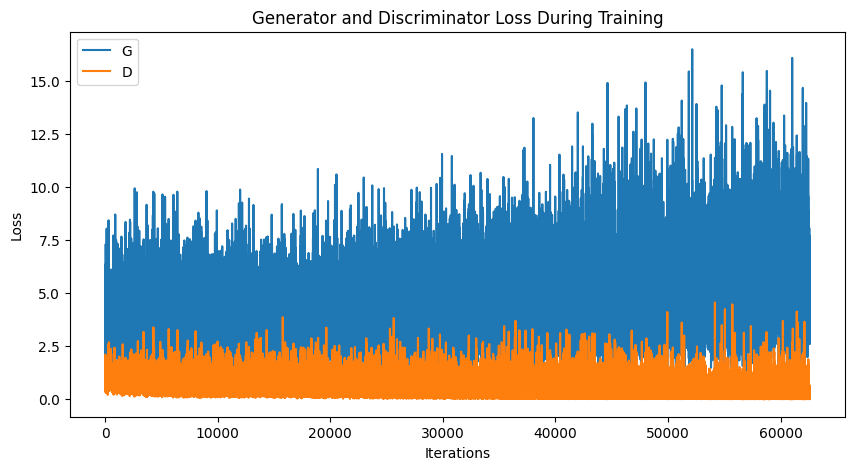

In [11]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
img_list = []
iters = 0
G_losses = []
D_losses = []
# Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        if data is None:
            continue
        images, descriptions = data
        b_size = images.size(0)
        real_images = images.to(device)
        
        encoded_texts = [encode_sentence(description).to(device) for description in descriptions]
        encoded_texts = torch.stack(encoded_texts)

        # Discriminator update
        netD.zero_grad()
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)
        output = netD(real_images).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise, encoded_texts)
        label.fill_(0)
        output = netD(fake_images.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Generator update
        netG.zero_grad()
        label.fill_(1)
        output = netD(fake_images).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()
        
        #print(f'Epoch [{epoch}/{num_epochs}], Batch [{i}/{len(dataloader)}]')
        # print(f'Text Embedded Vector Size: {encoded_texts.size()}')
        # print(f'Input Noise Vector Size: {noise.size()}')
        # print(f'Concatenated Input Size: {torch.cat((noise, encoded_texts.unsqueeze(-1).unsqueeze(-1)), 1).size()}')
        
        
        
        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD.item()} Loss_G: {errG.item()}')
            with torch.no_grad():
                fake = netG(noise, encoded_texts).detach().cpu()
                # Save grid image
                vutils.save_image(fake, f'{save_dir}/epoch_{epoch}_batch_{i}.png', normalize=True)
                # Save individual images
                for j, image in enumerate(fake):
                    vutils.save_image(image, f'{save_dir}/epoch_{epoch}_batch_{i}_image_{j}.png', normalize=True)
        
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
            
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(noise, encoded_texts).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
        iters += 1    
# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
# Save the model
model_save_dir = '/kaggle/working/models'
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

# Example to save after training
torch.save(netG.state_dict(), os.path.join(model_save_dir, 'generator_model.pth'))
torch.save(netD.state_dict(), os.path.join(model_save_dir, 'discriminator_model.pth'))

print(f"Models saved to: {model_save_dir}")


Models saved to: /kaggle/working/models


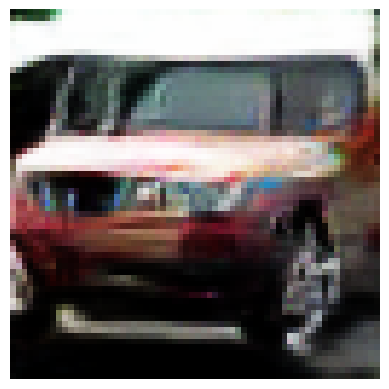

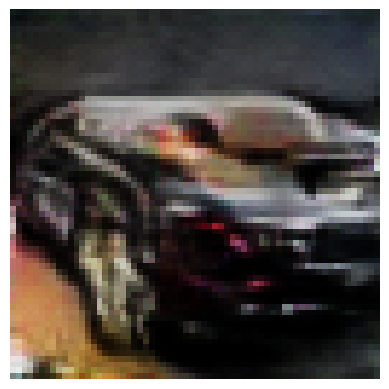

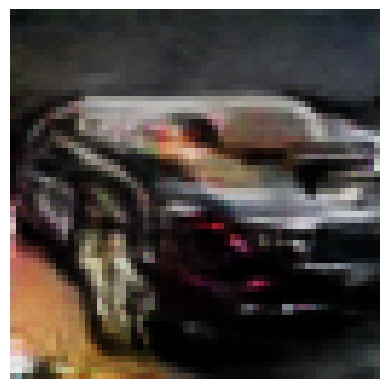

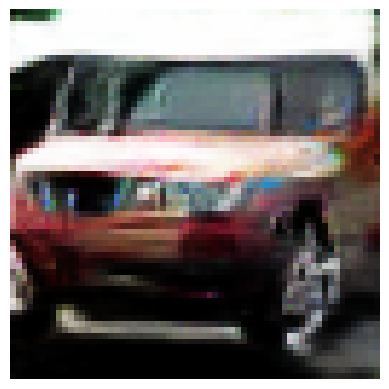

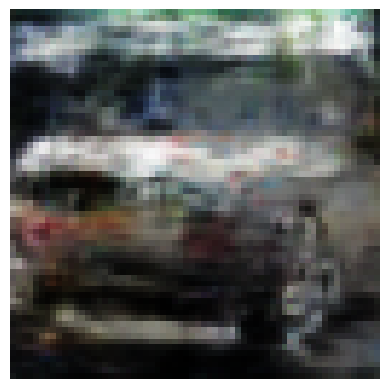

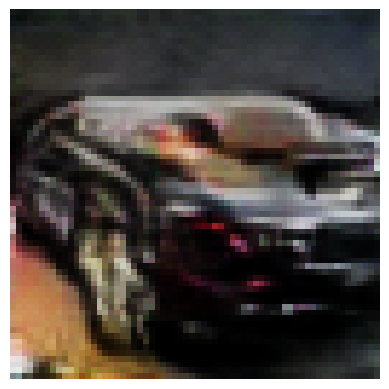

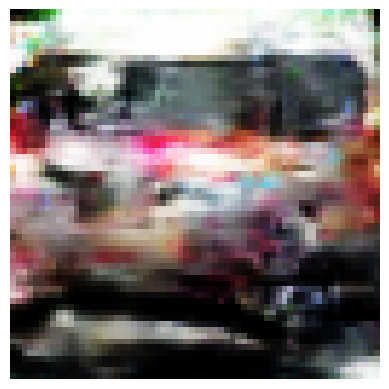

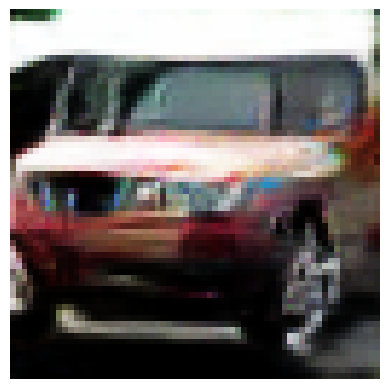

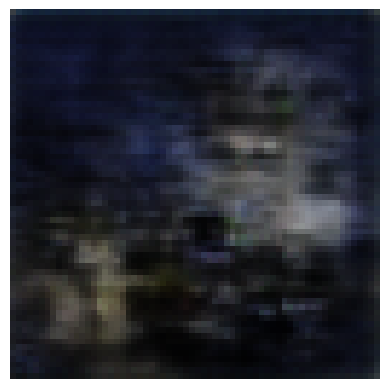

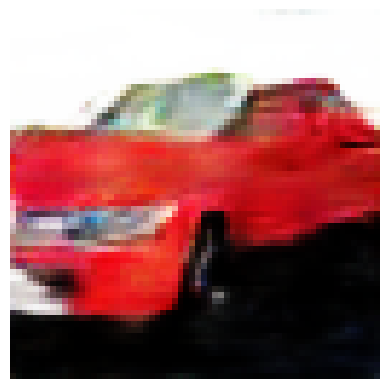

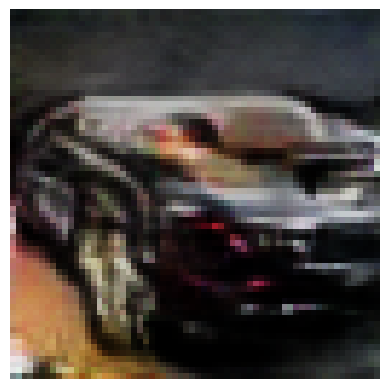

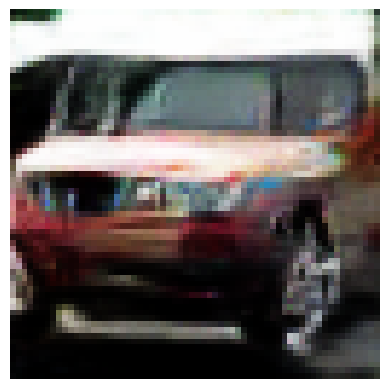

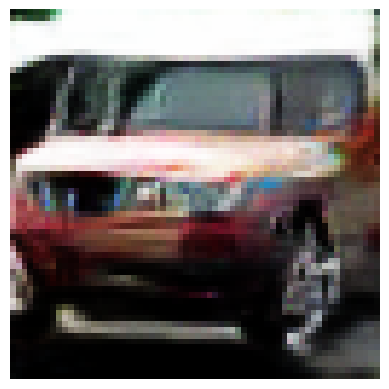

In [14]:
# Function to generate and display image from description
def generate_image_from_description(description):
    netG.eval()
    description_vector = encode_sentence(description).to(device)
    noise = torch.randn(1, nz, 1, 1, device=device)
    with torch.no_grad():
        fake_image = netG(noise, description_vector.unsqueeze(0)).squeeze(0).cpu()
    # Transpose the image tensor from (channels, height, width) to (height, width, channels)
    fake_image = np.transpose(fake_image.numpy(), (1, 2, 0))
    # Normalize and plot the image
    plt.imshow((fake_image + 1) / 2)  # Normalize the image to [0, 1] for proper visualization
    plt.axis('off')
    plt.show()


input_descriptions = [
    "A red sedan car",
    "A black SUV car ",
    "A black sports car",
    "A yellow sedan car",
    "A silver SUV car",
    "A green SUV car",
    "A red SUV car",
    "A black sedan car"
    "A blue sports car",
    "A red truck",
    "A silver sedan car",
    "A gray sedan car",
    "A red suv car"
]

for description in input_descriptions:
    generate_image_from_description(description)

# Model weights

Generator link - https://drive.google.com/file/d/1CepsQT6Wzvx4dqs2_wKt3y-SmP5JgFIw/view?usp=sharing
discriminator link - https://drive.google.com/file/d/1WWVqMg3XdM3fvUOe1fZsnvCoLwTf9QH_/view?usp=sharing